**Rozdział 14. Rekurencyjne sieci neuronowe**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 14._

# Konfiguracja

Upewnijmy się najpierw, że notatnik ten będzie działał w środowiskach Python 2 i 3, importujmy kilka powszechnie stosowanych modułów, upewnijmy się, że moduł MatplotLib będzie prawidłowo tworzył wykresy, a także przygotujmy funkcję zapisującą rysunki:

In [1]:
# Obsługa środowisk Python 2 i Python 3
from __future__ import division, print_function, unicode_literals

# Importowanie popularnych modułów
import numpy as np
import os

# W celu zachowania powtarzalności wyników w kolejnych przebiegach
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Generowanie ładnych wykresów
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Lokacja, w której będą zapisywane rysunki
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rsn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID, fig_id + ".png")
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Oczywiście, potrzebujemy również modułu TensorFlow:

In [2]:
import tensorflow as tf

# Podstawowe sieci rekurencyjne

## Ręczna implementacja

In [3]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [4]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val)

[[-0.0664006   0.96257669  0.68105793  0.70918542 -0.89821601]
 [ 0.9977755  -0.71978903 -0.99657607  0.96739239 -0.99989718]
 [ 0.99999774 -0.99898803 -0.99999893  0.99677622 -0.99999988]
 [ 1.         -1.         -1.         -0.99818915  0.99950868]]


In [6]:
print(Y1_val)

[[ 1.         -1.         -1.          0.40200251 -0.99999982]
 [-0.12210421  0.62805271  0.96718431 -0.99371219 -0.25839362]
 [ 0.99999827 -0.9999994  -0.9999975  -0.85943311 -0.99998808]
 [ 0.99928284 -0.99999815 -0.99990582  0.98579627 -0.92205757]]


## Korzystanie z funkcji `static_rnn()`

In [7]:
n_inputs = 3
n_neurons = 5

In [8]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

In [9]:
init = tf.global_variables_initializer()

In [10]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.65428472, -0.93850589,  0.52089024],
       [ 0.99122757, -0.95425421, -0.75180793, -0.99952078,  0.98202348],
       [ 0.99992681, -0.99783254, -0.82473528, -0.9999963 ,  0.99947774],
       [ 0.99677098, -0.68750614,  0.84199691,  0.93039107,  0.8120684 ]], dtype=float32)

In [12]:
Y1_val

array([[ 0.99998885, -0.99976051, -0.06679298, -0.99998039,  0.99982214],
       [-0.65249437, -0.51520866, -0.37968954, -0.59225935, -0.08968385],
       [ 0.99862403, -0.99715197, -0.03308626, -0.99915648,  0.99329019],
       [ 0.99681675, -0.95981938,  0.39660636, -0.83076048,  0.79671967]], dtype=float32)

In [13]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Wyciąga duże wartości stałych z obiektu graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Wizualizuje graf TensorFlow."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [14]:
show_graph(tf.get_default_graph())

## Sekwencje pakujące

In [15]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [16]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [17]:
init = tf.global_variables_initializer()

In [18]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # próbka 1
        [[3, 4, 5], [0, 0, 0]], # próbka 2
        [[6, 7, 8], [6, 5, 4]], # próbka 3
        [[9, 0, 1], [3, 2, 1]], # próbka 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [19]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.94288003 -0.99988687  0.94055814  0.99999851 -0.9999997 ]]

 [[-0.80015349 -0.99218267  0.78177971  0.9971031  -0.99646091]
  [-0.63711601  0.11300932  0.5798437   0.43105593 -0.63716984]]

 [[-0.93605185 -0.99983788  0.93088669  0.99998152 -0.99998295]
  [-0.9165386  -0.99456042  0.89605415  0.99987197 -0.99997509]]

 [[ 0.99273688 -0.99819332 -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746334 -0.73191994  0.7827872   0.95256817 -0.97817713]]]


In [20]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.94288003 -0.99988687  0.94055814  0.99999851 -0.9999997 ]
 [-0.63711601  0.11300932  0.5798437   0.43105593 -0.63716984]
 [-0.9165386  -0.99456042  0.89605415  0.99987197 -0.99997509]
 [-0.02746334 -0.73191994  0.7827872   0.95256817 -0.97817713]]


## Korzystanie z funkcji `dynamic_rnn()`

In [21]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [22]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [23]:
init = tf.global_variables_initializer()

In [24]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # próbka 1
        [[3, 4, 5], [0, 0, 0]], # próbka 2
        [[6, 7, 8], [6, 5, 4]], # próbka 3
        [[9, 0, 1], [3, 2, 1]], # próbka 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [25]:
print(outputs_val)

[[[ 0.80872238 -0.52312446 -0.6716494  -0.69762248 -0.54384488]
  [ 0.9995454   0.99339807 -0.99998379  0.99919224 -0.98379493]]

 [[ 0.99547106 -0.02155113 -0.99482894  0.17964774 -0.83173698]
  [-0.06013332  0.4030143   0.02884481 -0.29437575 -0.85681593]]

 [[ 0.99990267  0.49111056 -0.9999314   0.8413834  -0.9444679 ]
  [ 0.99406189  0.95815992 -0.99768937  0.98646194 -0.91752487]]

 [[-0.80632919  0.93928123 -0.97309881  0.99996096  0.97433066]
  [ 0.95047355 -0.51205158 -0.27763969  0.83108062  0.81631833]]]


In [26]:
show_graph(tf.get_default_graph())

## Wyznaczanie długości sekwencji

In [27]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [28]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

In [29]:
init = tf.global_variables_initializer()

In [30]:
X_batch = np.array([
        # takt 0     takt 1
        [[0, 1, 2], [9, 8, 7]], # próbka 1
        [[3, 4, 5], [0, 0, 0]], # próbka 2 (uzupełniona wektorami zerowymi)
        [[6, 7, 8], [6, 5, 4]], # próbka 3
        [[9, 0, 1], [3, 2, 1]], # próbka 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [31]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [32]:
print(outputs_val)

[[[ 0.04335003 -0.7907052   0.62847102 -0.16162854  0.82851923]
  [-0.23427293 -0.98320025  1.          0.05531176  0.13038807]]

 [[ 0.06481666 -0.98885179  0.99938971 -0.2837334   0.94707835]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.0862233  -0.9994626   0.99999934 -0.39728162  0.9843685 ]
  [-0.3956297  -0.49045283  0.99999118  0.26839557 -0.66423571]]

 [[-0.99486166  0.99336135  0.9999935   0.9048987  -0.99997759]
  [ 0.65352577 -0.56341326  0.99020594  0.72314984  0.30071661]]]


In [33]:
print(states_val)

[[-0.23427293 -0.98320025  1.          0.05531176  0.13038807]
 [ 0.06481666 -0.98885179  0.99938971 -0.2837334   0.94707835]
 [-0.3956297  -0.49045283  0.99999118  0.26839557 -0.66423571]
 [ 0.65352577 -0.56341326  0.99020594  0.72314984  0.30071661]]


## Uczenie klasyfikatora sekwencyjnego

Uwaga: w książce wykorzystywana jest funkcja `tensorflow.contrib.layers.fully_connected()` zamiast funkcji `tf.layers.dense()` (która jeszcze nie istniała w czasie pisania rozdziału). Obecnie zalecane jest używanie funkcji `tf.layers.dense()`, ponieważ wszelkie elementy modułu `contrib` mogą być modyfikowane lub usuwane bez zapowiedzi. Funkcja `dense()` jest niemal identyczna jak funkcja `fully_connected()`. Główne różnice istotne dla tego rozdziału są następujące:
* zmianie uległy nazwy kilku parametrów: `scope` został zmieniony na `name`, `activation_fn` staje się `activation` (w analogiczny sposób został usunięty przyrostek `_fn` z innych parametrów, takich jak `normalizer_fn`), `weights_initializer` jest przemianowany na `kernel_initializer` itd.,
* domyślną wartością parametru `activation` jest teraz `None`, a nie `tf.nn.relu`.

In [34]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/dane/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/dane/train-images-idx3-ubyte.gz
Extracting /tmp/dane/train-labels-idx1-ubyte.gz
Extracting /tmp/dane/t10k-images-idx3-ubyte.gz
Extracting /tmp/dane/t10k-labels-idx1-ubyte.gz


In [12]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Dokładność: zestaw uczący", acc_train, "zestaw testowy:", acc_test)

0 Dokładność: zestaw uczący 0.93333334 zestaw testowy: 0.9374
1 Dokładność: zestaw uczący 0.97333336 zestaw testowy: 0.961
2 Dokładność: zestaw uczący 0.97333336 zestaw testowy: 0.9734
3 Dokładność: zestaw uczący 0.98 zestaw testowy: 0.9702
4 Dokładność: zestaw uczący 0.96 zestaw testowy: 0.9668
5 Dokładność: zestaw uczący 0.98 zestaw testowy: 0.966
6 Dokładność: zestaw uczący 0.98 zestaw testowy: 0.9773
7 Dokładność: zestaw uczący 0.9533333 zestaw testowy: 0.9687
8 Dokładność: zestaw uczący 0.97333336 zestaw testowy: 0.9726
9 Dokładność: zestaw uczący 0.99333334 zestaw testowy: 0.9763
10 Dokładność: zestaw uczący 0.9866667 zestaw testowy: 0.9759
11 Dokładność: zestaw uczący 0.97333336 zestaw testowy: 0.9822
12 Dokładność: zestaw uczący 0.9866667 zestaw testowy: 0.9812
13 Dokładność: zestaw uczący 0.99333334 zestaw testowy: 0.979
14 Dokładność: zestaw uczący 0.9866667 zestaw testowy: 0.9832
15 Dokładność: zestaw uczący 0.9866667 zestaw testowy: 0.982
16 Dokładność: zestaw uczący 1.0 ze

# Wielowarstwowe sieci rekurencyjne

In [13]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [14]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [15]:
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [16]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Dokładność: zestaw uczący", acc_train, "zestaw testowy:", acc_test)

0 Dokładność: zestaw uczący 0.94 zestaw testowy: 0.9418
1 Dokładność: zestaw uczący 0.97333336 zestaw testowy: 0.9576
2 Dokładność: zestaw uczący 0.96 zestaw testowy: 0.9642
3 Dokładność: zestaw uczący 0.98 zestaw testowy: 0.9752
4 Dokładność: zestaw uczący 1.0 zestaw testowy: 0.9795
5 Dokładność: zestaw uczący 0.98 zestaw testowy: 0.9777
6 Dokładność: zestaw uczący 0.96666664 zestaw testowy: 0.9792
7 Dokładność: zestaw uczący 1.0 zestaw testowy: 0.9802
8 Dokładność: zestaw uczący 0.98 zestaw testowy: 0.9803
9 Dokładność: zestaw uczący 0.98 zestaw testowy: 0.9811


# Szeregi czasowe

In [17]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Zapisywanie rysunku wykres_szeregów_czasowych


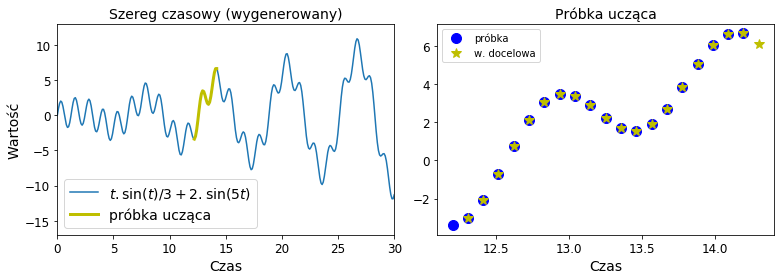

In [18]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("Szereg czasowy (wygenerowany)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "y-", linewidth=3, label="próbka ucząca")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Czas")
plt.ylabel("Wartość")

plt.subplot(122)
plt.title("Próbka ucząca", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="próbka")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="w. docelowa")
plt.legend(loc="upper left")
plt.xlabel("Czas")


save_fig("wykres_szeregów_czasowych")
plt.show()

In [19]:
X_batch, y_batch = next_batch(1, n_steps)

In [20]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.38452097,  2.05081182],
       [ 2.05081182,  2.29742291],
       [ 2.29742291,  2.0465599 ],
       [ 2.0465599 ,  1.34009916],
       [ 1.34009916,  0.32948704],
       [ 0.32948704, -0.76115235],
       [-0.76115235, -1.68967022],
       [-1.68967022, -2.25492776],
       [-2.25492776, -2.34576159],
       [-2.34576159, -1.96789418],
       [-1.96789418, -1.24220428],
       [-1.24220428, -0.37478448],
       [-0.37478448,  0.39387907],
       [ 0.39387907,  0.84815766],
       [ 0.84815766,  0.85045064],
       [ 0.85045064,  0.3752526 ],
       [ 0.3752526 , -0.48422846],
       [-0.48422846, -1.53852738],
       [-1.53852738, -2.54795941],
       [-2.54795941, -3.28097239]])

## Korzystanie z klasy `OuputProjectionWrapper`

Stwórzmy sieć RSN. Będzie zawierała 100 neuronów rekurencyjnych i będziemy ją rozwijać w 20 taktach, gdyż każda próbka ucząca będzie zajmowała tyle wejść do sieci. Każda dana wejściowa zawiera tylko jedną cechę (wartość w danym momencie). Próbki docelowe również stanowią sekwencję 20 danych wejściowych, z których każda zawiera pojedynczą wartość:

In [21]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

W każdym takcie uzyskujemy teraz wektor wyjściowy o rozmiarze 100. Zależy nam jednak na otrzymywaniu pojedynczej wartości wyjściowej w każdym takcie. Najprostszym rozwiązaniem jest "opakowanie" komórki wewnątrz klasy `OutputProjectionWrapper`.

In [22]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [23]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [24]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [25]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [26]:
saver = tf.train.Saver()

In [27]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tBłąd MSE:", mse)
    
    saver.save(sess, "./moj_model_szeregow_czasowych") # nieukazane w książce

0 	Błąd MSE: 10.261381
100 	Błąd MSE: 0.38783535
200 	Błąd MSE: 0.10971393
300 	Błąd MSE: 0.06142948
400 	Błąd MSE: 0.059208594
500 	Błąd MSE: 0.057419535
600 	Błąd MSE: 0.052253913
700 	Błąd MSE: 0.046964772
800 	Błąd MSE: 0.04941703
900 	Błąd MSE: 0.047623064
1000 	Błąd MSE: 0.047578864
1100 	Błąd MSE: 0.046452977
1200 	Błąd MSE: 0.04004542
1300 	Błąd MSE: 0.046569455
1400 	Błąd MSE: 0.041250996


In [28]:
with tf.Session() as sess:                          # nieukazane w książce
    saver.restore(sess, "./moj_model_szeregow_czasowych")   # nieukazane

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./moj_model_szeregow_czasowych


In [29]:
y_pred

array([[[-3.4015713 ],
        [-2.4648154 ],
        [-1.065511  ],
        [ 0.69048625],
        [ 2.145151  ],
        [ 3.110319  ],
        [ 3.4750142 ],
        [ 3.3476262 ],
        [ 2.7957058 ],
        [ 2.2065432 ],
        [ 1.671819  ],
        [ 1.5209379 ],
        [ 1.8635523 ],
        [ 2.7135623 ],
        [ 3.8195097 ],
        [ 5.0859127 ],
        [ 6.092083  ],
        [ 6.6383862 ],
        [ 6.6529365 ],
        [ 6.0492744 ]]], dtype=float32)

Zapisywanie rysunku wykres_prognoz_szeregu_czasowego


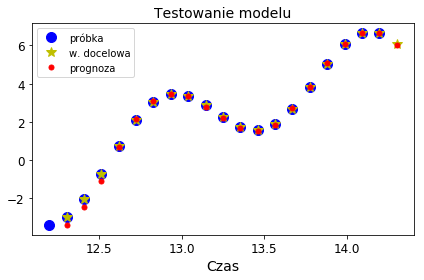

In [30]:
plt.title("Testowanie modelu", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="próbka")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="w. docelowa")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prognoza")
plt.legend(loc="upper left")
plt.xlabel("Czas")

save_fig("wykres_prognoz_szeregu_czasowego")
plt.show()

## Metoda niewykorzystująca klasy `OutputProjectionWrapper`

In [31]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [32]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [33]:
n_outputs = 1
learning_rate = 0.001

In [34]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [35]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [36]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tBłąd MSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./moj_model_szeregow_czasowych")

0 	Błąd MSE: 13.907031
100 	Błąd MSE: 0.50563276
200 	Błąd MSE: 0.1972298
300 	Błąd MSE: 0.1026313
400 	Błąd MSE: 0.067478806
500 	Błąd MSE: 0.06297704
600 	Błąd MSE: 0.05659878
700 	Błąd MSE: 0.050051264
800 	Błąd MSE: 0.0505437
900 	Błąd MSE: 0.04874706
1000 	Błąd MSE: 0.04847027
1100 	Błąd MSE: 0.050347283
1200 	Błąd MSE: 0.041849542
1300 	Błąd MSE: 0.05084179
1400 	Błąd MSE: 0.043897416


In [65]:
y_pred

array([[[-3.44828582],
        [-2.48405623],
        [-1.13649726],
        [ 0.71962416],
        [ 2.01745081],
        [ 3.13937259],
        [ 3.54828739],
        [ 3.36234236],
        [ 2.77184248],
        [ 2.10781217],
        [ 1.64527285],
        [ 1.5579648 ],
        [ 1.87219918],
        [ 2.7233479 ],
        [ 3.85228252],
        [ 5.06193066],
        [ 6.07513857],
        [ 6.63054752],
        [ 6.59069633],
        [ 5.9993453 ]]], dtype=float32)

Zapisywanie rysunku wykres_prognoz_szeregu_czasowego_2


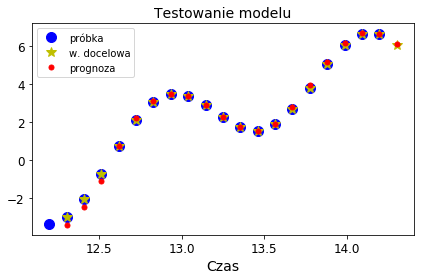

In [37]:
plt.title("Testowanie modelu", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="próbka")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="w. docelowa")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prognoza")
plt.legend(loc="upper left")
plt.xlabel("Czas")

save_fig("wykres_prognoz_szeregu_czasowego_2")
plt.show()

## Twórcze generowanie nowej sekwencji

In [38]:
with tf.Session() as sess:                        # nieukazane w książce
    saver.restore(sess, "./moj_model_szeregow_czasowych") # nieukazane

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./moj_model_szeregow_czasowych


Zapisywanie rysunku wykres_sekwencji


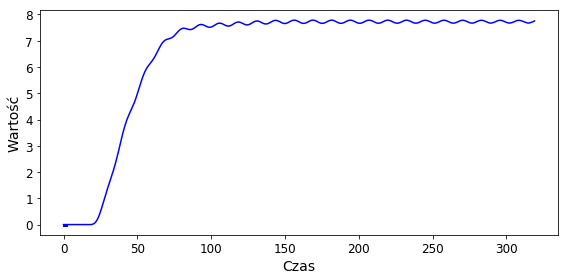

In [39]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Czas")
plt.ylabel("Wartość")
save_fig("wykres_sekwencji")
plt.show()

INFO:tensorflow:Restoring parameters from ./moj_model_szeregow_czasowych
Zapisywanie rysunku wykres_twórczej_sekwencji


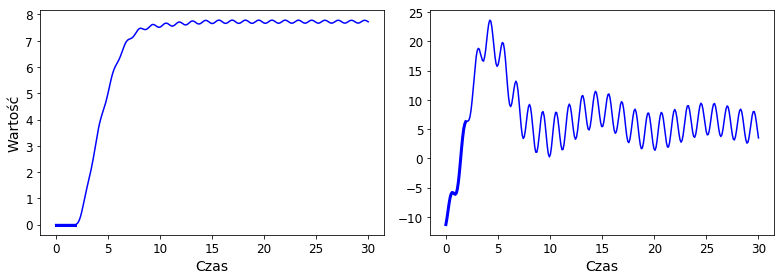

In [40]:
with tf.Session() as sess:
    saver.restore(sess, "./moj_model_szeregow_czasowych")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Czas")
plt.ylabel("Wartość")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Czas")
save_fig("wykres_twórczej_sekwencji")
plt.show()

# Głębokie sieci rekurencyjne

## Klasa MultiRNNCell

In [70]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [71]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [72]:
init = tf.global_variables_initializer()

In [73]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [74]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [75]:
outputs_val.shape

(2, 5, 100)

## Rozmieszczanie głębokiej sieci rekurencyjnej pomiędzy wiele kart graficznych

**NIE** rób tego:

In [72]:
with tf.device("/gpu:0"):  # ŹLE! Ta instrukcja jest ignorowana.
    layer1 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

with tf.device("/gpu:1"):  # ŹLE! Również jest ignorowana.
    layer2 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

Potrzebujemy natomiast klasę `DeviceCellWrapper`:

In [73]:
import tensorflow as tf

class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [74]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [75]:
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # w przypadku kart graficznych - ["/gpu:0", "/gpu:1", "/gpu:2"]
cells = [DeviceCellWrapper(dev,tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Ewentualnie od wersji 1.1 modułu TensorFlow możesz skorzystać z klasy `tf.contrib.rnn.DeviceWrapper` (od wersji 1.2 alias `tf.nn.rnn_cell.DeviceWrapper`).

In [76]:
init = tf.global_variables_initializer()

In [77]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

[[[ 0.06828325 -0.11375451  0.06424566 ..., -0.24244198 -0.04821674
   -0.12077257]
  [ 0.07453813 -0.2251049   0.20471548 ..., -0.14811224 -0.0922538
   -0.04429063]
  [ 0.13780868 -0.14680631 -0.0095655  ..., -0.08136044  0.07381541
   -0.03125775]
  ..., 
  [-0.25400278 -0.32078549  0.39923593 ..., -0.26669216  0.33505771
   -0.03757669]
  [ 0.22596692 -0.09880773 -0.27422303 ..., -0.13385999 -0.25443044
   -0.36498186]
  [ 0.1655937  -0.33435836  0.34313348 ..., -0.36904442  0.06908746
    0.46574104]]

 [[ 0.00489879 -0.03151967  0.02628033 ..., -0.19341362 -0.0730375
    0.00451888]
  [ 0.03073939 -0.0579551   0.17785911 ..., -0.20945786  0.05200011
   -0.07436937]
  [ 0.00192378 -0.25690764  0.12488247 ...,  0.02644884 -0.25046453
   -0.12239399]
  ..., 
  [-0.13501379 -0.06209698  0.1595035  ..., -0.20012119 -0.3338365
   -0.09281697]
  [-0.44347292  0.20323271  0.12526961 ..., -0.07962411  0.27046496
    0.31884009]
  [ 0.23965777 -0.22903362  0.07749593 ..., -0.02653922  0.08

## Porzucanie

In [41]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [42]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

Uwaga: parametr `input_keep_prob` może być węzłem zastępczym, dzięki czemu jesteśmy w stanie wyznaczać mu dowolną wartość w trakcie uczenia, a podczas testowania ustanawiać wartość 1.0 (całkowicie wyłączyć porzucanie). Jest to znacznie bardziej eleganckie rozwiązanie w porównaniu do metod wykorzystywanych we wcześniejszych wydaniach książki (tzn. pisania własnej klasy opakowującej lub tworzenia osobnych modeli do uczenia i testowania). Dziękuję Shenowi Chengowi za zwrócenie na to uwagi.

In [43]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [44]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # nieukazane w książce
            print(iteration, "Błąd MSE uczenia:", mse) # nieukazane
    
    saver.save(sess, "./moj_model_szeregów_czasowych_z_porzucaniem")

0 Błąd MSE uczenia: 15.747096
100 Błąd MSE uczenia: 4.968555
200 Błąd MSE uczenia: 4.0872583
300 Błąd MSE uczenia: 3.5342572
400 Błąd MSE uczenia: 3.0189364
500 Błąd MSE uczenia: 3.0615802
600 Błąd MSE uczenia: 2.8228593
700 Błąd MSE uczenia: 3.4641318
800 Błąd MSE uczenia: 3.4054976
900 Błąd MSE uczenia: 4.2956448
1000 Błąd MSE uczenia: 3.1168485
1100 Błąd MSE uczenia: 4.0756845
1200 Błąd MSE uczenia: 3.5756016
1300 Błąd MSE uczenia: 3.2438366
1400 Błąd MSE uczenia: 4.712628


In [46]:
with tf.Session() as sess:
    saver.restore(sess, "./moj_model_szeregów_czasowych_z_porzucaniem")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./moj_model_szeregów_czasowych_z_porzucaniem


Zapisywanie rysunku wykres_prognoz_szeregu_czasowego_3


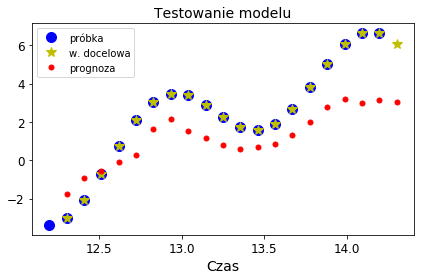

In [47]:
plt.title("Testowanie modelu", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="próbka")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="w. docelowa")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prognoza")
plt.legend(loc="upper left")
plt.xlabel("Czas")

save_fig("wykres_prognoz_szeregu_czasowego_3")
plt.show()

Ups, wydaje się, że metoda porzucania wcale nam nie pomaga w tym przypadku. :/

# Komórka LSTM

In [85]:
reset_graph()

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

In [86]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="strata")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [87]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [88]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [89]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoka", epoch, "Dokładność: zbiór uczący =", acc_train, "zbiór testowy =", acc_test)

Epoch 0 Train accuracy = 0.946667 Test accuracy = 0.9506
Epoch 1 Train accuracy = 0.98 Test accuracy = 0.9691
Epoch 2 Train accuracy = 0.993333 Test accuracy = 0.9745
Epoch 3 Train accuracy = 0.993333 Test accuracy = 0.982
Epoch 4 Train accuracy = 0.973333 Test accuracy = 0.9819
Epoch 5 Train accuracy = 0.993333 Test accuracy = 0.9838
Epoch 6 Train accuracy = 0.993333 Test accuracy = 0.9799
Epoch 7 Train accuracy = 0.993333 Test accuracy = 0.9873
Epoch 8 Train accuracy = 1.0 Test accuracy = 0.9862
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9873


In [90]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

In [91]:
gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

# Wektory właściwościowe

Ta część notatnika bazuje na [samouczku Word2Vec](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

## Dostarczanie danych

In [92]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "zestawy danych/słowa"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Tworzy katalogi, nic nie szkodzi, jeśli będą już istnieć.
    
    Kod działa w środowisku Python 2. Aby zadziałał w wersji Python >=3.2, wystarczy użyć poniższego wiersza:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [93]:
words = fetch_words_data()

In [94]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

## Tworzenie słownika

In [95]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [96]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5242, 3081,   12,    6,  195,    2, 3136,   46,   59]))

In [97]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'default originated as a term of presidency first used'

In [98]:
words[24], data[24]

('culottes', 0)

## Generowanie grup

In [99]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window cel skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # etykieta docelowa pośrodku buforu
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [100]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [101]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [102]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5242],
        [   6],
        [3081],
        [  12],
        [ 195],
        [   2],
        [   6]], dtype=int32),
 ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a'])

## Tworzenie modelu

In [103]:
batch_size = 128
embedding_size = 128  # Rozmiar wektora właściwościowego.
skip_window = 1       # Liczba słów branych pod uwagę po lewej i prawej.
num_skips = 2         # Liczba wielokrotnych użyć wejścia w celu wygenerowania etykiety. 

# Wybieramy losowy zbiór walidacyjny w celu próbokowania najbliższych sąsiadów. Ograniczamy tu
# próbki walidacyjne do słów o niewielkim identyfikatorze numerycznym, które
# również występują najczęściej na etapie konstruowania.
valid_size = 16     # Losowy zestaw słów służący do oceny podobieństwa.
valid_window = 100  # Bierzemy tylko próbki z czoła rozkładu.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Liczba próbkowanych przykładów negatywnych.

learning_rate = 0.01

In [104]:
reset_graph()

# Dane wejściowe.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [105]:
vocabulary_size = 50000
embedding_size = 150

# Wyszukuje wektory właściwościowe dla danych wejściowych.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [106]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [107]:
# Konstruuje zmienne dla funkcji straty NCE. 
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Oblicza średnią wartość straty NCE dla grupy.
# Metoda tf.nce_loss automatycznie rysuje nową próbkę negatywnych etykiet za każdym razem,
# gdy określamy funkcję straty.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Tworzy optymalizator Adam
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Oblicza podobieństwo kosinusowe pomiędzy próbkami mini-grup i wszystkimi wektorami właściwościowymi.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Dodaje inicjator zmiennych.
init = tf.global_variables_initializer()

## Uczenie modelu

In [108]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rPrzebieg: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # Wykonujemy jeden krok aktualizacji poprzez przeprowadzenie operacji uczenia (dołączając ją 
        # do listy zwracanych wartości dla metody session.run()).
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # Średnia strata stanowi oszacowanie straty dla wcześniejszych 2000 grup. 
            print("Średnia strata w takcie ", step, ": ", average_loss)
            average_loss = 0

        # Zwróć uwagę, że proces ten jest kosztowny (spowolnienie rzędu ~20%, jeśli obliczenia są przeprowadzane co 500 taktów).
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # liczba najbliższych sąsiadów
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Najbliżej do %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  285.895568848
Nearest to would: stems, secessionist, coronary, provers, surpasses, subscriber, losing, excommunicated,
Nearest to on: enumerative, camus, biochemical, skeptic, idealised, sooty, grossman, flashing,
Nearest to four: maj, glue, doubt, emil, civilis, generative, bested, necrosis,
Nearest to his: exerted, talmudic, switzerland, particles, somehow, standstill, value, hau,
Nearest to often: billed, shrine, lems, aalborg, prescriptions, winger, manichaeism, sox,
Nearest to in: charlestown, cobe, moody, appeals, dauphin, buenos, liar, inuit,
Nearest to an: rota, haihowak, melatonin, graham, guaranteeing, catalyze, pcd, gobind,
Nearest to eight: onstage, usn, brl, guevara, arbitrate, wild, radiocarbon, manning,
Nearest to these: thames, natufian, lasted, genghis, amitabh, dodo, bain, thorne,
Nearest to nine: mindstorms, blocks, proceed, tn, nihilist, elucidated, aspects, intermediate,
Nearest to called: humanoid, dealing, writ, gracefully,

Zachowajmy ostateczne wektory właściwościowe (oczywiście, jeśli wolisz, możesz użyć węzła `Saver`):

In [109]:
np.save("./moje_ostateczne_wektory_właściwościowe.npy", final_embeddings)

## Wykresy wektorów właściwościowych

In [110]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "Więcej etykiet niż wektorów właściwościowych"
    plt.figure(figsize=(18, 18))  # w calach
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

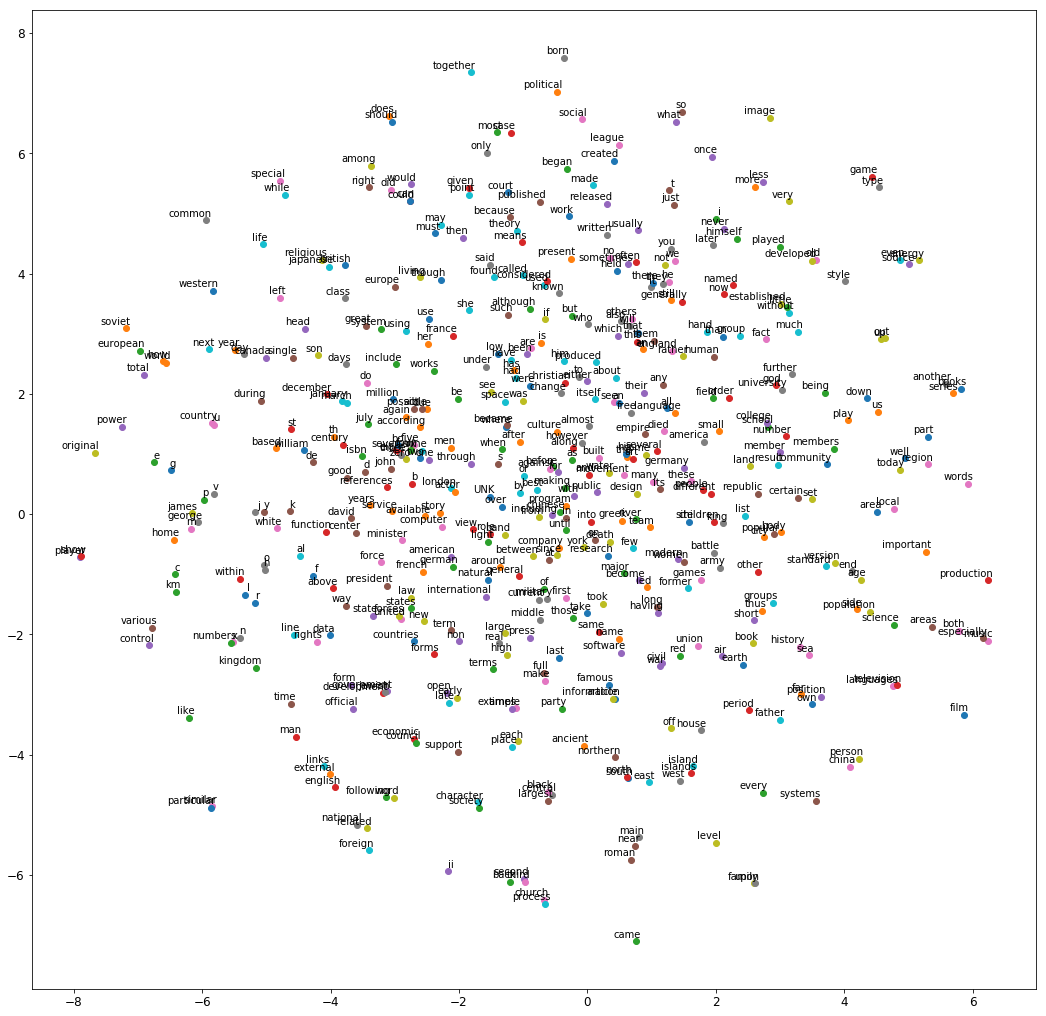

In [111]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Tłumaczenie maszynowe

Funkcja `basic_rnn_seq2seq()` tworzy prosty model koder/dekoder: najpierw wykorzystuje sieć rekurencyjną do zakodowania danych `encoder_inputs` jako wektor stanu, a następnie uruchamia dekoder zainicjowany wraz z ostatnim stanem kodera wobec danych `decoder_inputs`. Koder i dekoder wykorzystują ten sam rodzaj komórki RSN, ale mają osobne parametry.

In [112]:
import tensorflow as tf
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # Zdania w języku angielskim
Y = tf.placeholder(tf.int32, [None, n_steps]) # Zdania w języku francuskim
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # Lista jednowymiarowych tensorów
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # Lista jednowymiarowych tensorów

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [113]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# Rozwiązania ćwiczeń

## 1. do 6.

Patrz dodatek A.

## 7. Osadzone gramatyki Rebera

Najpierw musimy skonstruować funkcję generującą ciągi znaków na podstawie gramatyki. Gramatyka ta będzie reprezentowana w postaci listy możliwych przejść dla każdego stanu. Przejście określa, jaki ciąg znaków ma zostać umieszczony na wyjściu (lub jaki ma zostać wygenerowany przez gramatykę), a także następny stan.

In [114]:
from random import choice, seed

# W celu zachowania powtarzalności wyników w kolejnych przebiegach
seed(42)
np.random.seed(42)

default_reber_grammar = [
    [("B", 1)],           # (stan 0) =B=>(stan 1)
    [("T", 2), ("P", 3)], # (stan 1) =T=>(stan 2) lub =P=>(stan 3)
    [("S", 2), ("X", 4)], # (stan 2) =S=>(stan 2) lub =X=>(stan4)
    [("T", 3), ("V", 5)], # i tak dalej...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (stan 6) =E=>(stan końcowy)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        production, state = choice(grammar[state])
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Wygenerujmy kilka ciągów znaków na podstawie domyślnej gramatyki Rebera:

In [115]:
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTTTVPXTTTTTVPSE BTXSE BTXXTVPSE BTXXVPSE BTSSXXTTVVE BTXSE BTSSSXSE BPTTTVVE BTXXVVE BPTTVVE BTSXXTTTTVPSE BPTTVVE BPTVPSE BPTTVPXVVE BPVPXTTTVPXTVPSE BTXSE BPTTTTVPXTTTTTTTVPXVVE BPTVVE BTXSE BPTTTVVE BTSXXVPSE BTXXTTTTTVVE BPTTVPSE BPVVE BPTTTVPXVPXTTTTTVPXTTVVE 

Wygląda dobrze. Wygenerujemy teraz kilka ciągów znaków na podstawie osadzonej gramatyki Rebera:

In [116]:
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BPBPTVVEPE BTBPTVPXVVETE BPBPTTTVVEPE BPBTXSEPE BPBPTTTTTVPSEPE BTBTSXSETE BPBPVPSEPE BPBPVVEPE BPBTXSEPE BPBTSXSEPE BTBPTTVVETE BPBPVVEPE BTBTXSETE BPBPTTVVEPE BTBTSXXVVETE BTBTXXTVPXTVPSETE BTBPTVVETE BPBPVPXTTVPXTVVEPE BTBTXSETE BPBTXSEPE BPBTSXXTVPSEPE BPBPVVEPE BPBPTTTTTTTTTTVPXVVEPE BPBPVVEPE BPBPVVEPE 

W porządku, potrzebujemy teraz funkcji generującej ciągi znaków nieprzestrzegających gramatyki. Moglibyśmy wygenerować losowy ciąg znaków, ale zadanie byłoby wtedy nieco zbyt proste, dlatego zamiast tego stworzymy ciąg znaków przestrzegający reguł gramatyki, a następnie popsujemy go poprzez zmianę tylko jednego znaku:

In [117]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = choice(list(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Spójrzmy na kilka "popsutych" ciągów znaków:

In [118]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BPBPVPPEPE BPBPXSEPE BPBPTVVPPE BTBPTPSETE BTBPVVBTE BPBTSSXXTPTVVEPE BPPTSXXTVPSEPE BPBTXSSPE BTBPTTTVPSPTE BPBTSXXTTTSTTVVEPE BPBBXXVPXTVPXTTVVEPE BPBPTTVBEPE BPBPVVETE BPEPTTVVEPE BPBPVTSEPE BPBTXXXVVEPE BXBPTTTVPXVVETE BPBTSSXBEPE BPBPVBEPE BSBTXSEPE BTBPTVPXVPXVVETB TPBTSXXTVPXVPSEPE BPBTSXXTTTVXSEPE BPBPVPXVVSPE BTBTSBSETE 

Nie jest możliwe bezpośrednie dostarczenie ciągu znaków do sieci rekurencyjnej: najpierw musimy przekształcić go w sekwencję wektorów. Każdy wektor będzie symbolizował pojedynczą literę poprzez kodowanie "gorącojedynkowe". Na przykład literę B będzie reprezentował wektor `[1, 0, 0, 0, 0, 0, 0]`, literę E - wektor `[0, 1, 0, 0, 0, 0, 0]` itd. Napiszmy funkcję przekształcającą ciąg znaków w sekwencję takich wektorów "gorącojedynkowych". Zwróć uwagę, że jeśli ciag znaków będzie krótszy od tensora `n_steps`, zostanie automatycznie uzupełniony wektorami zerowymi (później podamy modułowi TensorFlow rzeczywistą długość każdego ciągu znaków za pomocą parametru `sequence_length`).

In [119]:
def string_to_one_hot_vectors(string, n_steps, chars="BEPSTVX"):
    char_to_index = {char: index for index, char in enumerate(chars)}
    output = np.zeros((n_steps, len(chars)), dtype=np.int32)
    for index, char in enumerate(string):
        output[index, char_to_index[char]] = 1.
    return output

In [120]:
string_to_one_hot_vectors("BTBTXSETE", 12)

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int32)

Możemy teraz wygenerować zbiór danych zawierający po 50% prawidłowych i nieprawidłowych ciągów znaków:

In [121]:
def generate_dataset(size):
    good_strings = [generate_string(embedded_reber_grammar)
                    for _ in range(size // 2)]
    bad_strings = [generate_corrupted_string(embedded_reber_grammar)
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    n_steps = max([len(string) for string in all_strings])
    X = np.array([string_to_one_hot_vectors(string, n_steps)
                  for string in all_strings])
    seq_length = np.array([len(string) for string in all_strings])
    y = np.array([[1] for _ in range(len(good_strings))] +
                 [[0] for _ in range(len(bad_strings))])
    rnd_idx = np.random.permutation(size)
    return X[rnd_idx], seq_length[rnd_idx], y[rnd_idx]

In [122]:
X_train, l_train, y_train = generate_dataset(10000)

Przyjrzyjmy się pierwszym próbkom uczącym:

In [123]:
X_train[0]

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0,

Widzimy, że tensor jest wypełniony dużą liczbą zer, poniważ najdłuższy ciąg znaków w zbiorze danych ma taką długość. Jaki rozmiar ma ten konrektny ciąg znaków?

In [124]:
l_train[0]

23

Do jakiej klasy należy?

In [125]:
y_train[0]

array([0])

Znakomiecie! Możemy teraz stworzyć sieć RSN rozpoznającą prawidłowe ciągi znaków. Tworzymy klasyfikator sekwencji bardzo podobny do skonstruowanego przez nas wcześniej do klasyfikowania cyfr MNIST; dwie główne różnice to:
* po pierwsze, wejściowe ciągi znaków mają zmienną długość, zatem musimy określić wartość parametru `sequence_length` podczas wywoływania funkcji `dynamic_rnn()`,
* po drugie, jest to klasyfikator binarny, zatem potrzebujemy tylko jednego neuronu wyjściowego podającego w wyniku oszacowany logarytm prawdopodobieństwa mówiący, czy dany ciąg znaków jest prawidłowy. W przypadku klasyfikacji wieloklasowej korzystaliśmy z funkcji `sparse_softmax_cross_entropy_with_logits()`, natomiast w przypadku klasyfikacji binarnej zastąpimy ją funkcją `sigmoid_cross_entropy_with_logits()`.


In [126]:
reset_graph()

possible_chars = "BEPSTVX"
n_inputs = len(possible_chars)
n_neurons = 30
n_outputs = 1

learning_rate = 0.02
momentum = 0.95

X = tf.placeholder(tf.float32, [None, None, n_inputs], name="X")
seq_length = tf.placeholder(tf.int32, [None], name="dlugosc_sekw")
y = tf.placeholder(tf.float32, [None, 1], name="y")

gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(gru_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

logits = tf.layers.dense(states, n_outputs, name="logity")
y_pred = tf.cast(tf.greater(logits, 0.), tf.float32, name="y_prog")
y_proba = tf.nn.sigmoid(logits, name="y_prawd")

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="strata")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=momentum,
                                       use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.equal(y_pred, y, name="prawidlowe")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Wygenerujmy teraz zbiór walidacyjny, dzięki czemu będziemy mogli śledzić postępy w trakcie uczenia:

In [127]:
X_val, l_val, y_val = generate_dataset(5000)

In [128]:
n_epochs = 50
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        X_batches = np.array_split(X_train, len(X_train) // batch_size)
        l_batches = np.array_split(l_train, len(l_train) // batch_size)
        y_batches = np.array_split(y_train, len(y_train) // batch_size)
        for X_batch, l_batch, y_batch in zip(X_batches, l_batches, y_batches):
            loss_val, _ = sess.run(
                [loss, training_op],
                feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, seq_length: l_val, y: y_val})
        print("{:4d}F. straty dla zb. uczącego: {:.4f}, dokładność: {:.2f}%  dokładność dla zb. walidacyjnego: {:.2f}%".format(
            epoch, loss_val, 100 * acc_train, 100 * acc_val))
        saver.save(sess, "moj_klasyfikator_gramatyka_rebera")

   0  Train loss: 0.6869, accuracy: 54.00%  Validation accuracy: 58.86%
   1  Train loss: 0.6651, accuracy: 54.00%  Validation accuracy: 59.56%
   2  Train loss: 0.6379, accuracy: 72.00%  Validation accuracy: 71.92%
   3  Train loss: 0.5612, accuracy: 66.00%  Validation accuracy: 72.88%
   4  Train loss: 0.4574, accuracy: 82.00%  Validation accuracy: 78.56%
   5  Train loss: 0.3446, accuracy: 84.00%  Validation accuracy: 85.80%
   6  Train loss: 0.3048, accuracy: 88.00%  Validation accuracy: 87.96%
   7  Train loss: 0.3263, accuracy: 90.00%  Validation accuracy: 91.28%
   8  Train loss: 0.2017, accuracy: 94.00%  Validation accuracy: 94.92%
   9  Train loss: 0.1600, accuracy: 98.00%  Validation accuracy: 95.06%
  10  Train loss: 0.1414, accuracy: 98.00%  Validation accuracy: 96.20%
  11  Train loss: 0.0723, accuracy: 98.00%  Validation accuracy: 98.26%
  12  Train loss: 0.0181, accuracy: 100.00%  Validation accuracy: 98.70%
  13  Train loss: 0.0769, accuracy: 100.00%  Validation accurac

Przetestujmy teraz naszą sieć rekurencyjną wobec dwóch podchwytliwych ciągów znaków: pierwszy jest "popsuty", a drugi prawidłowy. Różnią się one jedynie przedostatnim znakiem. Jeżeli sieć RSN poda prawidłowy wynik, to będzie oznaczało, że nauczyła się rozpoznawać wzór gramatyki Rebera. Aby to osiągnąć, wymagana byłaby długa pamięć krókoterminowa (dlatego wprowadziliśmy komórkę GRU).

In [129]:
test_strings = [
    "BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVETE",
    "BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVEPE"]
l_test = np.array([len(s) for s in test_strings])
max_length = l_test.max()
X_test = [string_to_one_hot_vectors(s, n_steps=max_length)
          for s in test_strings]

with tf.Session() as sess:
    saver.restore(sess, "moj_klasyfikator_gramatyka_rebera")
    y_proba_val = y_proba.eval(feed_dict={X: X_test, seq_length: l_test})

print()
print("Oszacowane prawdopodobieństwo wygenerowania ciągów znaków za pomocą reguł gramatyki Rebera:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, y_proba_val[index][0]))

INFO:tensorflow:Restoring parameters from my_reber_classifier

Estimated probability that these are Reber strings:
BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVETE: 0.00%
BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVEPE: 1.00%


Ta-da! Model działa prawidłowo. Sieć RSN określiła dobrze odpowiedzi ze stuprocentową pewnością. :)

## 8. i 9.

Wkrótce...